Lecture: AI I - Advanced 

Previous:
[**Chapter 2.3: Ensemble**](../02_training/03_ensemble.ipynb)

---

# Chapter 3.1: PyTorch Lightning

Over the past sections, you've written a lot of training code. Every time you trained a model, you wrote the same pattern:

```python
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            # ... accumulate metrics
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            break
```

This **boilerplate code**—the repetitive structure that's essentially the same for every project—accounts for 80% of your training scripts. You've written this pattern for regularization experiments, hyperparameter tuning, and ensemble training. Each time, you had to remember to call `optimizer.zero_grad()`, switch between `model.train()` and `model.eval()`, handle early stopping, save checkpoints, and more.

**What if you could focus on what makes your model unique** (the architecture, the loss function, the optimization strategy) and let a framework handle all the repetitive parts?

This is exactly what **PyTorch Lightning** provides: it automates the training infrastructure while keeping the flexibility and simplicity of PyTorch.

## What is PyTorch Lightning?

**PyTorch Lightning** is a lightweight wrapper around PyTorch that organizes your code and eliminates boilerplate while preserving full PyTorch flexibility. Think of it as **PyTorch with built-in best practices**.

The core philosophy: **Separate research code (what makes your model unique) from engineering code (the repetitive training infrastructure).**

## Key Features

Following are some of the key features of PyTorch Lightning

### 1. LightningModule: Organized Model Definition

Instead of scattered functions, everything related to your model lives in one class:

```python
class MyModel(L.LightningModule):
    def __init__(self):
        # Define layers
    
    def forward(self, x):
        # Forward pass (same as PyTorch nn.Module)
    
    def training_step(self, batch, batch_idx):
        # What happens in one training step
    
    def validation_step(self, batch, batch_idx):
        # What happens in one validation step
    
    def configure_optimizers(self):
        # Which optimizer and scheduler to use
```

**What it replaces**: Your manual training and validation loops, scattered across multiple functions.

### 2. Trainer: Automated Training Loop

One object handles all training infrastructure:

```python
trainer = L.Trainer(
    max_epochs=100,
    accelerator='auto',  # Automatic GPU/CPU selection
    devices='auto',
    callbacks=[EarlyStopping(), ModelCheckpoint()],
    logger=TensorBoardLogger('logs/')
)
trainer.fit(model, train_loader, val_loader)
```

**What it replaces**:
- Your entire training loop (epoch iteration, batch iteration)
- `model.train()` / `model.eval()` switching
- `optimizer.zero_grad()`, `loss.backward()`, `optimizer.step()`
- Device placement (`.to(device)`)
- Gradient accumulation
- Gradient clipping

### 3. Callbacks: Modular Functionality

Add features without modifying your core code:

```python
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(monitor='val_loss', save_top_k=3),
    LearningRateMonitor(logging_interval='epoch')
]
```

**What it replaces**:
- Manual early stopping logic (patience counters, best model tracking)
- Manual checkpoint saving (`torch.save()`)
- Manual learning rate tracking

Built-in callbacks:
- `EarlyStopping`: Stop when metric stops improving
- `ModelCheckpoint`: Save best models automatically
- `LearningRateMonitor`: Track LR changes
- `RichProgressBar`: Beautiful progress bars
- `Timer`: Track training time
- `Custom callbacks`: Easy to create your own!

### 4. Automatic Device Placement

Seamless integration with logging frameworks:

```python
# In training_step:
self.log('train_loss', loss)
self.log('train_acc', acc, prog_bar=True)

# Automatically logged to TensorBoard, W&B, etc.
```

**What it replaces**: Manual `writer.add_scalar()` calls, metric tracking dictionaries.

Supported loggers:
- TensorBoard (built-in)
- Weights & Biases
- MLflow
- Neptune
- Comet
- CSV Logger

### 6. Automatic Optimization

Lightning handles the optimization loop:

```python
# In training_step - just return the loss!
def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    loss = F.cross_entropy(y_hat, y)
    return loss  # Lightning does optimizer.zero_grad(), backward(), step()
```

**What it replaces**: The entire optimizer loop (zero_grad, backward, step).

For advanced cases, you can use manual optimization if needed.

### 7. Hyperparameter Saving

Automatically save hyperparameters:

```python
def __init__(self, hidden_dim, learning_rate, dropout):
    super().__init__()
    self.save_hyperparameters()  # Saves all arguments automatically
```

**What it replaces**: Manual hyperparameter tracking and logging.

### 8. Testing and Prediction

Clean separation of training, validation, and testing:

```python
def test_step(self, batch, batch_idx):
    # What happens during testing
    pass

# Run testing
trainer.test(model, test_loader)
```

**What it replaces**: Duplicate validation code repurposed for testing.

## PyTorch Lightning Example

In [3]:
import torch

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)  # set random seed for reproducibility

iris = datasets.load_iris()
x = iris.data  # 4 features: sepal length, sepal width, petal length, petal width
y = iris.target  # 3 classes: setosa, versicolor, virginica

x_scaled = StandardScaler().fit_transform(x)
x_train, x_temp, y_train, y_temp = train_test_split(
    x_scaled, y, test_size=0.4, random_state=42, stratify=y
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

batch_size = 16
train_loader = DataLoader(TensorDataset(torch.FloatTensor(x_train), torch.LongTensor(y_train)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(x_val), torch.LongTensor(y_val)), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test)), batch_size=batch_size)

### Model Definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L


class IrisClassifier(L.LightningModule):
    """
    Lightning module for Iris classification.
    All model logic in one organized place!
    """
    def __init__(self, input_dim=4, hidden_dim=64, output_dim=3, learning_rate=0.001, dropout=0.2):
        super().__init__()
        self.save_hyperparameters() # Save hyperparameters (automatically logged!)
        
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """Forward pass - same as PyTorch"""
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.layer2(x)
        return x
    
    def _step(self, step_name, batch, batch_idx):
        """Common step for training, validation, and testing"""
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)

        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()
        
        # Log metrics (automatically sent to logger)
        self.log(f'{step_name}_loss', loss, prog_bar=True)
        self.log(f'{step_name}_acc', acc, prog_bar=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        """
        Defines what happens in ONE training step.
        Lightning handles the loop, optimization, and device placement!
        """
        return self._step('train', batch, batch_idx) 
    
    def validation_step(self, batch, batch_idx):
        """What happens in ONE validation step"""
        self._step('val', batch, batch_idx) 

    def test_step(self, batch, batch_idx):
        """What happens in ONE test step"""
        self._step('test', batch, batch_idx)

    def configure_optimizers(self):
        """
        Define optimizer and (optionally) learning rate scheduler.
        Return optimizer or dict with optimizer and scheduler.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate) 
        return {'optimizer': optimizer}

### Training the Model

In [6]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger


model = IrisClassifier(hidden_dim=64, learning_rate=0.001, dropout=0.2)
callbacks = [
    # Early stopping: stop when val_loss doesn't improve for 15 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        mode='min',
        verbose=True
    ),
    
    # Model checkpoint: save top 3 models based on val_loss
    ModelCheckpoint(
        monitor='val_loss',
        dirpath='./data/01_lightning/models/',
        filename='iris-{epoch:02d}-{val_loss:.4f}',
        save_top_k=3,
        mode='min'
    )
]

trainer = L.Trainer(
    max_epochs=100,
    accelerator='auto',  # Automatically use GPU if available
    devices='auto',
    callbacks=callbacks,
    logger=TensorBoardLogger('./data/01_lightning/logs', name='iris_classifier'),
    log_every_n_steps=5,
    enable_progress_bar=True
)
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores



  | Name    | Type    | Params | Mode  | FLOPs
----------------------------------------------------
0 | layer1  | Linear  | 320    | train | 0    
1 | dropout | Dropout | 0      | train | 0    
2 | layer2  | Linear  | 195    | train | 0    
----------------------------------------------------
515       Trainable params
0         Non-trainable params
515       Total params
0.002     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 1.006


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 0.929


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 0.861


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.800


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 0.747


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.047 >= min_delta = 0.0. New best score: 0.699


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.657


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.621


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.589


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.561


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.535


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.513


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.493


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.475


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.459


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.445


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.431


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.419


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.408


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.398


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.388


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.379


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.370


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.362


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.356


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.349


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.342


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.336


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.330


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.324


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.318


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.312


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.306


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.301


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.295


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.290


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.285


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.281


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.276


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.271


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.267


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.263


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.259


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.255


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.250


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.246


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.241


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.236


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.232


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.227


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.224


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.221


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.217


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.214


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.210


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.207


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.204


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.201


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.198


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.195


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.193


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.191


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.188


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.185


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.182


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.180


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.178


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.176


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.174


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.171


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.168


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.166


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.164


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.162


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.159


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.159


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.158


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.156


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.154


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.152


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.150


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.149


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.146


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.145


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.143


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.141


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.140


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.139


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.137


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.136


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.134


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.132


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.131


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.129


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.128


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.127


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.125


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.125


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.124
`Trainer.fit` stopped: `max_epochs=100` reached.


### Evaluation

In [9]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = IrisClassifier.load_from_checkpoint(best_model_path)
best_model.eval()

IrisClassifier(
  (layer1): Linear(in_features=4, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (layer2): Linear(in_features=64, out_features=3, bias=True)
)

In [18]:
from sklearn.metrics import classification_report

y_pred = best_model(torch.FloatTensor(x_test)).argmax(dim=1)

print(classification_report(y_test, y_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



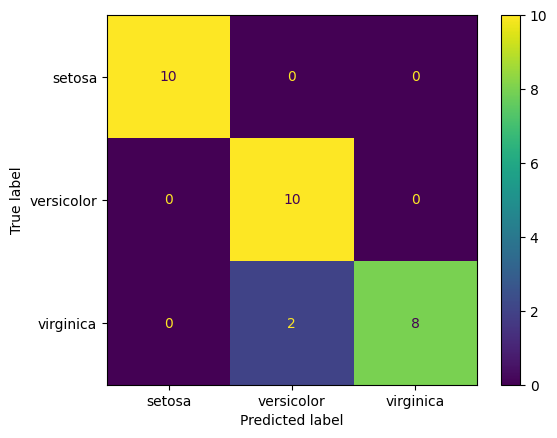

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=iris.target_names)

In [20]:
%load_ext tensorboard
%tensorboard --host 0.0.0.0 --port=8080  --logdir=./data/01_lightning/logs

---

Lecture: AI I - Basics 

Exercise: [**Exercise 2.1: Python Basics**](../02_python/exercises/01_basics.ipynb)

Next: [**Chapter 2.2: Data Structures**](../02_python/02_data_structures.ipynb)